## Setup

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Requires TensorFlow >=2.11 for the GroupNormalization layer.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, ConvLSTM2D, BatchNormalization, Conv3D
from tensorflow.keras.callbacks import *

import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

2024-07-31 13:28:39.939636: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-31 13:28:40.035567: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 13:28:40.711585: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-07-31 13:28:40.711632: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

## Hyperparameters

In [23]:
batch_size = 256
num_epochs = 800         # Just for the sake of demonstration
total_timesteps = 1000   # 1000
norm_groups = 8          # Number of groups used in GroupNormalization layer
learning_rate = 1e-4

img_size_H = 32
img_size_W = 64
img_channels = 5

first_conv_channels = 64
channel_multiplier = [1, 2, 4, 8]
widths = [first_conv_channels * mult for mult in channel_multiplier]
has_attention = [False, False, True, True]
num_res_blocks = 2  # Number of residual blocks

## Gaussian diffusion utilities

We define the **forward process** and the **reverse process** as a separate utility. Most of the code in this utility has been borrowed
from the original implementation with some slight modifications.

In [24]:
from layers.diffusion import GaussianDiffusion

## Network architecture

U-Net, originally developed for semantic segmentation, is an architecture that is
widely used for implementing diffusion models but with some slight modifications:

1. The network accepts two inputs: Image and time step
2. Self-attention between the convolution blocks once we reach a specific resolution
(16x16 in the paper)
3. Group Normalization instead of weight normalization

We implement most of the things as used in the original paper. We use the
`swish` activation function throughout the network. We use the variance scaling
kernel initializer.

The only difference here is the number of groups used for the
`GroupNormalization` layer. For the flowers dataset,
we found that a value of `groups=8` produces better results
compared to the default value of `groups=32`. Dropout is optional and should be
used where chances of over fitting is high. In the paper, the authors used dropout
only when training on CIFAR10.

In [25]:
from tensorflow.keras.models import load_model

pretrained_encoder = load_model('../saved_models/encoder_cnn_56deg_5var.h5')
# pretrained_encoder.summary()

In [26]:
# Extract the first 5 layers
first_five_layers = pretrained_encoder.layers[:5]

# Display the first four layers to confirm
for i, layer in enumerate(first_five_layers):
    print(f"Layer {i}: {layer}")

# Create a new model using these layers
# Get the input of the pre-trained model
input_layer = pretrained_encoder.input

# Get the output of the fourth layer
output_layer = first_five_layers[-1].output

# Create the new model
pretrained_encoder = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Print the summary of the new model
pretrained_encoder.summary()

Layer 0: <keras.engine.input_layer.InputLayer object at 0x7f0cc4649a50>
Layer 1: <keras.layers.convolutional.conv2d.Conv2D object at 0x7f0c90771cc0>
Layer 2: <keras.layers.convolutional.conv2d.Conv2D object at 0x7f0c90773130>
Layer 3: <keras.layers.convolutional.conv2d.Conv2D object at 0x7f0d1412abf0>
Layer 4: <keras.layers.convolutional.conv2d.Conv2D object at 0x7f0d141c7130>
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 64, 5)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 64, 32)        672       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 64, 128)       16512     
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 64, 256)       131328    
         

In [27]:
for layer in pretrained_encoder.layers:
    layer.trainable = False

pretrained_encoder._name = 'encoder'

In [28]:
from layers.denoiser import build_unet_model_c2

In [29]:
# Build the unet model
network = build_unet_model_c2(
    img_size_H=img_size_H,
    img_size_W=img_size_W,
    img_channels=img_channels,
    widths=widths,
    has_attention=has_attention,
    num_res_blocks=num_res_blocks,
    norm_groups=norm_groups,
    first_conv_channels=first_conv_channels,
    activation_fn=keras.activations.swish,
    encoder=pretrained_encoder,
)

image_input_past_embed1 shape: (None, 32, 64, 64)
image_input_past_embed2 shape: (None, 32, 64, 64)
image_input_past shape: (None, 32, 64, 64)
image_input_past shape: (None, 2048, 64)
x.shape: (None, 32, 64, 64) temb.shape: (None, 256)


In [30]:
# network.summary()

## Training

In [31]:
class DiffusionModel(keras.Model):
    def __init__(self, network, ema_network, timesteps, gdf_util, ema=0.999):
        super().__init__()
        self.network = network  # denoiser or noise predictor
        self.ema_network = ema_network
        self.timesteps = timesteps
        self.gdf_util = gdf_util
        self.ema = ema

    def train_step(self, data):
        # Unpack the data
        (images, image_input_past1, image_input_past2), y = data
        
        # 1. Get the batch size
        batch_size = tf.shape(images)[0]
        
        # 2. Sample timesteps uniformly
        t = tf.random.uniform(minval=0, maxval=self.timesteps, shape=(batch_size,), dtype=tf.int64)

        with tf.GradientTape() as tape:
            # 3. Sample random noise to be added to the images in the batch
            noise = tf.random.normal(shape=tf.shape(images), dtype=images.dtype)
            print("noise.shape:", noise.shape)
            
            # 4. Diffuse the images with noise
            images_t = self.gdf_util.q_sample(images, t, noise)
            print("images_t.shape:", images_t.shape)
            
            # 5. Pass the diffused images and time steps to the network
            pred_noise = self.network([images_t, t, image_input_past1, image_input_past2], training=True)
            print("pred_noise.shape:", pred_noise.shape)
            
            # 6. Calculate the loss
            loss = self.loss(noise, pred_noise)

        # 7. Get the gradients
        gradients = tape.gradient(loss, self.network.trainable_weights)

        # 8. Update the weights of the network
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        # 9. Updates the weight values for the network with EMA weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(self.ema * ema_weight + (1 - self.ema) * weight)

        # 10. Return loss values
        return {"loss": loss}

    
    def test_step(self, data):
        # Unpack the data
        (images, image_input_past1, image_input_past2), y = data

        # 1. Get the batch size
        batch_size = tf.shape(images)[0]
        
        # 2. Sample timesteps uniformly
        t = tf.random.uniform(minval=0, maxval=self.timesteps, shape=(batch_size,), dtype=tf.int64)

        # 3. Sample random noise to be added to the images in the batch
        noise = tf.random.normal(shape=tf.shape(images), dtype=images.dtype)
        
        # 4. Diffuse the images with noise
        images_t = self.gdf_util.q_sample(images, t, noise)
        
        # 5. Pass the diffused images and time steps to the network
        pred_noise = self.network([images_t, t, image_input_past1, image_input_past2], training=False)
        
        # 6. Calculate the loss
        loss = self.loss(noise, pred_noise)

        # 7. Return loss values
        return {"loss": loss}



# Build the unet model
network = build_unet_model_c2(
    img_size_H=img_size_H,
    img_size_W=img_size_W,
    img_channels=img_channels,
    widths=widths,
    has_attention=has_attention,
    num_res_blocks=num_res_blocks,
    norm_groups=norm_groups,
    first_conv_channels=first_conv_channels,
    activation_fn=keras.activations.swish,
    encoder=pretrained_encoder,
)

ema_network = build_unet_model_c2(
    img_size_H=img_size_H,
    img_size_W=img_size_W,
    img_channels=img_channels,
    widths=widths,
    has_attention=has_attention,
    num_res_blocks=num_res_blocks,
    norm_groups=norm_groups,
    first_conv_channels=first_conv_channels,
    activation_fn=keras.activations.swish,
    encoder=pretrained_encoder,
)
ema_network.set_weights(network.get_weights())  # Initially the weights are the same

image_input_past_embed1 shape: (None, 32, 64, 64)
image_input_past_embed2 shape: (None, 32, 64, 64)
image_input_past shape: (None, 32, 64, 64)
image_input_past shape: (None, 2048, 64)
x.shape: (None, 32, 64, 64) temb.shape: (None, 256)
image_input_past_embed1 shape: (None, 32, 64, 64)
image_input_past_embed2 shape: (None, 32, 64, 64)
image_input_past shape: (None, 32, 64, 64)
image_input_past shape: (None, 2048, 64)
x.shape: (None, 32, 64, 64) temb.shape: (None, 256)


In [32]:
# ema_network.summary()

### Load trained model

In [33]:
# Get an instance of the Gaussian Diffusion utilities
gdf_util = GaussianDiffusion(timesteps=total_timesteps)

# Get the model
model = DiffusionModel(
    network=network,
    ema_network=ema_network,
    gdf_util=gdf_util,
    timesteps=total_timesteps,
)

In [34]:
# Restore weights
# model.load_weights('../checkpoints/ddpm_weather_56c2_56_5var_cp3')  # full version of CoDiCast 1000 steps
model.load_weights('../checkpoints/ddpm_weather_56c2_56_5var_cp3_1000')  # full version of CoDiCast 1000 steps

## Results

In [35]:
from utils.normalization import batch_norm, batch_norm_reverse
from utils.metrics import lat_weighted_rmse_one_var, lat_weighted_acc_one_var

In [36]:
resolution_folder = '56degree'
resolution = '5.625'  #1.40625, 2.8125, 5.625
var_num = '5'

test_data_tf = np.load("/home/scratch/ERA5/" + resolution_folder + "/merged_data/concat_2017_2018_" + resolution + "_" + var_num + "var.npy")
test_data_tf = test_data_tf.transpose((0, 2, 3, 1))
test_data_tf.shape

(2920, 32, 64, 5)

In [37]:
test_data_tf_norm = batch_norm(test_data_tf, test_data_tf.shape, batch_size=1460)
test_data_tf_norm.shape

(2920, 32, 64, 5)

In [38]:
test_data_tf_norm_pred = test_data_tf_norm[2:]
test_data_tf_norm_past1 = test_data_tf_norm[:-2]
test_data_tf_norm_past2 = test_data_tf_norm[1:-1]

print(test_data_tf_norm_pred.shape, test_data_tf_norm_past1.shape, test_data_tf_norm_past2.shape)

(2918, 32, 64, 5) (2918, 32, 64, 5) (2918, 32, 64, 5)


### One example of t+6 ~ t+72

In [39]:
import tensorflow as tf
import numpy as np

def generate_images(model, original_samples, original_samples_past1, original_samples_past2):
    """
    @model: trained denoiser
    @original_samples: it just provides the shape, does not involve generation
    @original_samples_past: conditions from the past
    """
    num_images = original_samples.shape[0]
    img_size_H = original_samples.shape[1]
    img_size_W = original_samples.shape[2]
    img_channels = original_samples.shape[3]
    total_timesteps = model.timesteps  # Ensure this is defined in your model

    # 1. Randomly sample noise (starting point for reverse process)
    samples = tf.random.normal(shape=(num_images, img_size_H, img_size_W, img_channels), dtype=tf.float32)
    
    # 2. Sample from the model iteratively
    for t in reversed(range(0, total_timesteps)):
        tt = tf.cast(tf.fill([num_images], t), dtype=tf.int64)
        pred_noise = model.ema_network.predict([samples, tt, original_samples_past1, original_samples_past2],
                                               verbose=0, 
                                               batch_size=num_images
                                              )
        samples = model.gdf_util.p_sample(pred_noise, samples, tt, clip_denoised=True)
        
    # 3. Return generated samples and original samples
    return original_samples, samples
    # return original_samples.numpy(), samples.numpy()

In [40]:
gen_start_idx = 0
gen_end_idx = 12

original_samples = tf.convert_to_tensor(test_data_tf_norm_pred[gen_start_idx:gen_end_idx], dtype=tf.float32)
original_samples_past1 = tf.convert_to_tensor(test_data_tf_norm_past1[gen_start_idx:gen_end_idx], dtype=tf.float32)
original_samples_past2 = tf.convert_to_tensor(test_data_tf_norm_past2[gen_start_idx:gen_end_idx], dtype=tf.float32)

print(original_samples.shape, original_samples_past1.shape, original_samples_past2.shape)

(12, 32, 64, 5) (12, 32, 64, 5) (12, 32, 64, 5)


In [41]:
import time


def predict_autoregressive(model, initial_inputs, prediction_horizon):
    
    predictions = []
    
    original_sample, sample_past1, sample_past2 = initial_inputs[0], initial_inputs[1], initial_inputs[2]  # t, t-2, t-1

    start_time = time.time()
    
    for _ in range(prediction_horizon):
        # Predict the next time step
        original_sample, generated_sample = generate_images(model, original_sample, sample_past1, sample_past2)
        
        print("original_sample.shape:", original_sample.shape, "generated_sample.shape:", generated_sample.shape)
        
        # Append the prediction to the list of predictions
        predictions.append(generated_sample)

        sample_past1 = sample_past2
        sample_past2 = generated_sample
        
    end_time = time.time()
    epoch_duration = end_time - start_time
    print(f'Generating 12 samples use {epoch_duration:.2f} s')
    
    # Concatenate predictions along the time steps axis
    predictions = np.concatenate(predictions, axis=0)
    return predictions

In [47]:
initial_inputs = [tf.convert_to_tensor(original_samples[0:1], dtype=tf.float32),
                  tf.convert_to_tensor(original_samples_past1[0:1], dtype=tf.float32), 
                  tf.convert_to_tensor(original_samples_past2[0:1], dtype=tf.float32)
                 ]  # t, t-2, t-1

prediction_horizon = 12

future_predictions = predict_autoregressive(model, initial_inputs, prediction_horizon)
print(future_predictions.shape)

original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
Generating 12 samples use 894.95 s
(12, 32, 64, 5)


In [48]:
original_samples_unnormlalized = batch_norm_reverse(test_data_tf, test_data_tf.shape, 1459, original_samples)
generated_samples_unnormlalized = batch_norm_reverse(test_data_tf, test_data_tf.shape, 1459, future_predictions)

print(original_samples_unnormlalized.shape, generated_samples_unnormlalized.shape)

(12, 32, 64, 5) (12, 32, 64, 5)


In [52]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

def plot_images1(samples, sample_type, lead_time):
    
    fig, axs = plt.subplots(1, 5, figsize=(20, 3), subplot_kw={'projection': ccrs.PlateCarree()})
    axs = axs.flatten()  # Flatten the array of axes for easier indexing

    channels = ['Z500', 'T850', 'T2m', 'U10', 'V10']
    
    # Define latitude and longitude ranges
    latitudes = np.linspace(-90, 90, samples.shape[1])
    longitudes = np.linspace(-180, 180, samples.shape[2])
    
    # Set number of ticks
    num_lat_ticks = 5
    num_lon_ticks = 7
    
    lat_ticks = np.linspace(-90, 90, num_lat_ticks)
    lon_ticks = np.linspace(-180, 180, num_lon_ticks)
    
    for i in range(len(channels)):
        im = axs[i].imshow(samples[lead_time, :, :, i], aspect='auto', cmap='viridis', extent=[-180, 180, -90, 90], transform=ccrs.PlateCarree())
        axs[i].set_title(f"{channels[i]}", fontsize=22)
        
        # Set x and y axis labels
        if i == 0:
            axs[i].set_ylabel(str(sample_type), fontsize=22)
        
        # Add coastlines with lighter color
        axs[i].coastlines(color='black', linewidth=1.0)

        # Add gridlines with labels and hide the gridlines
        # gl = axs[i].gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linestyle='--')
        # gl.xlines = False  # Hide the x gridlines
        # gl.ylines = False  # Hide the y gridlines
        # gl.top_labels = False
        # gl.right_labels = False
        # gl.xlocator = plt.FixedLocator(lon_ticks)
        # gl.ylocator = plt.FixedLocator(lat_ticks)

        # Set the tick labels manually
        axs[i].set_xticks(lon_ticks)
        axs[i].set_xticklabels([f'{lon:.0f}°' for lon in lon_ticks], fontsize=14)
        axs[i].set_yticks(lat_ticks)
        axs[i].set_yticklabels([f'{lat:.0f}°' for lat in lat_ticks], fontsize=14)

        cbar = fig.colorbar(im, ax=axs[i], orientation='horizontal')
        cbar.ax.tick_params(labelsize=11)
    
    plt.tight_layout()
    plt.show()

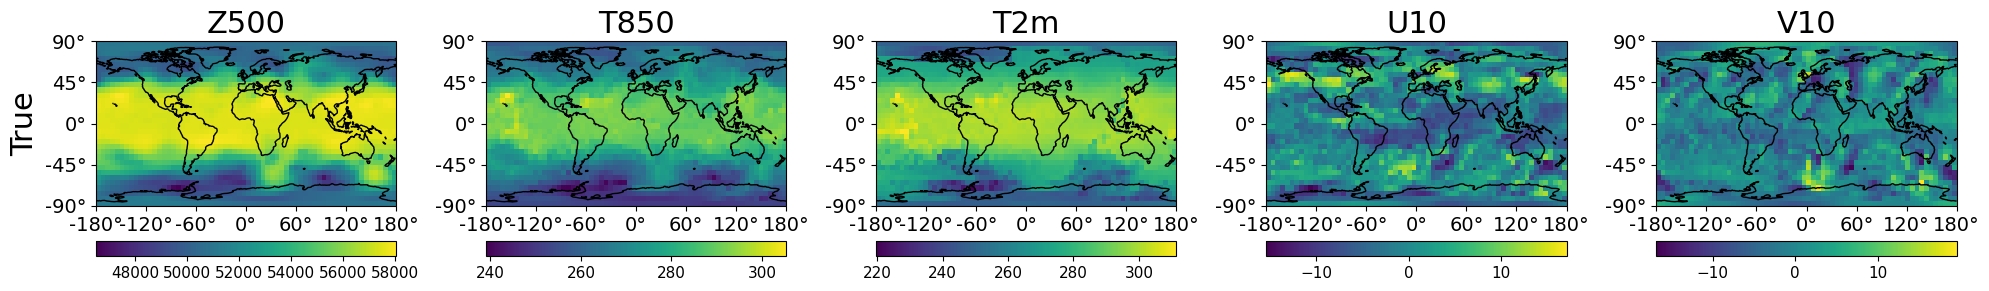

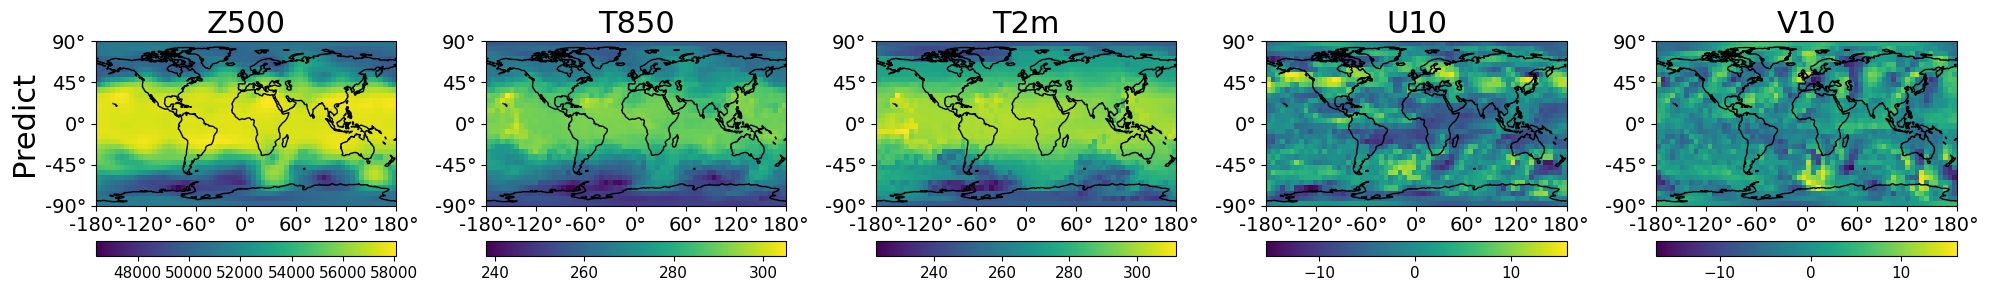

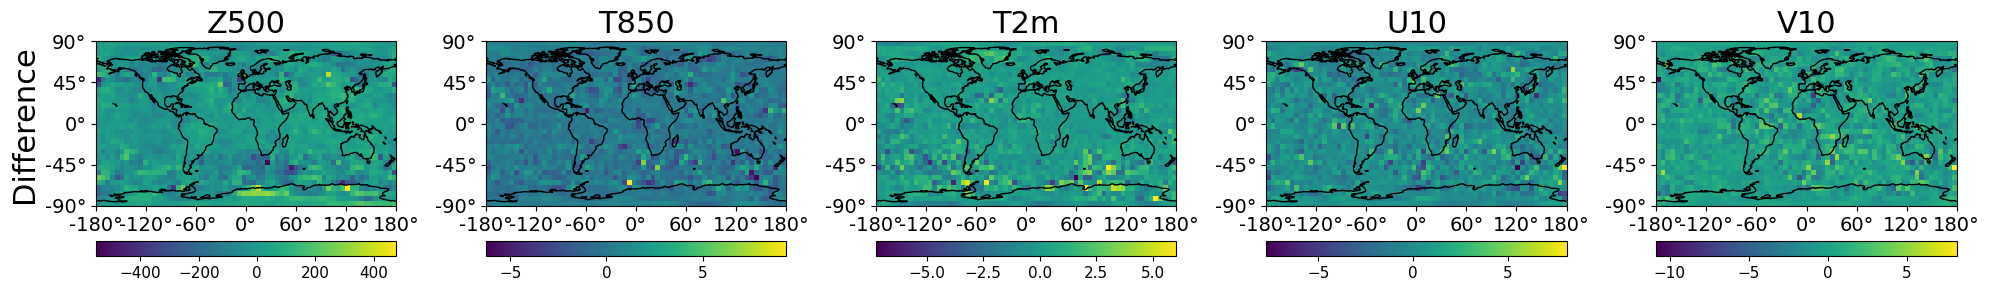

In [53]:
# lead_time = {0 ~ 11} representing 6~72 hours lead time

lead_time = 0

plot_images1(original_samples_unnormlalized, 'True', lead_time)
plot_images1(generated_samples_unnormlalized, 'Predict', lead_time)
plot_images1(original_samples_unnormlalized-generated_samples_unnormlalized, 'Difference', lead_time)

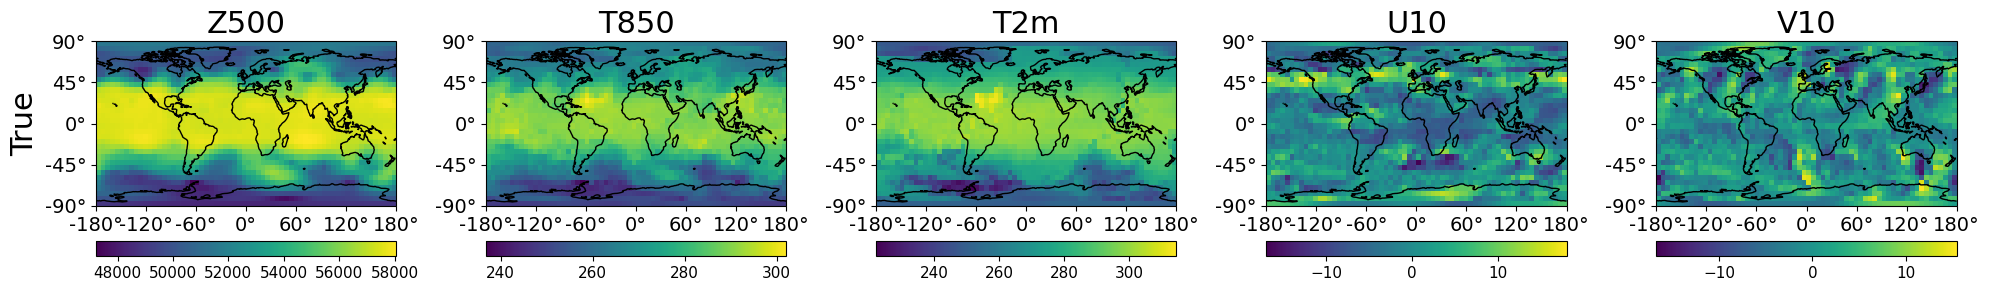

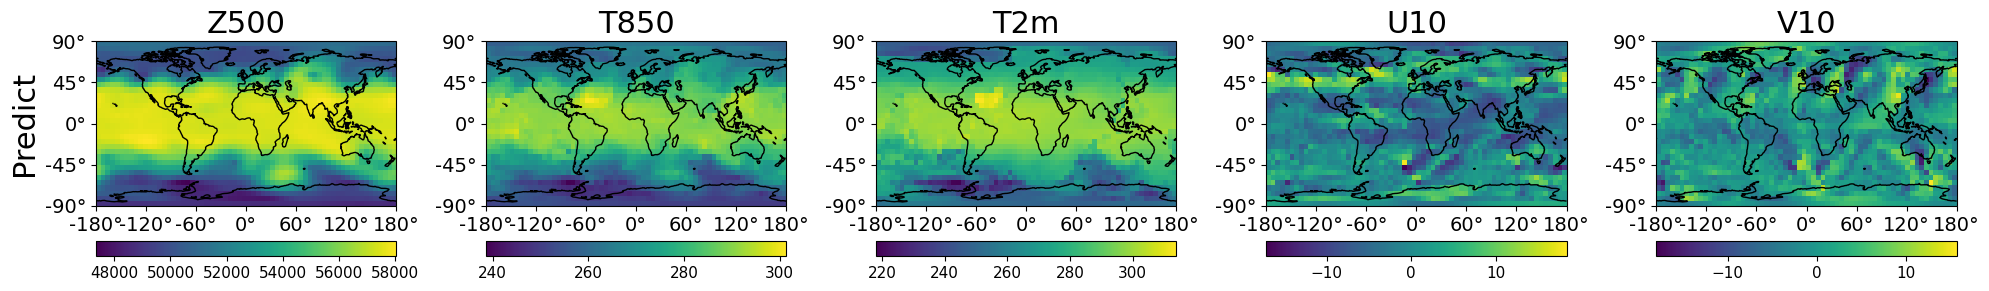

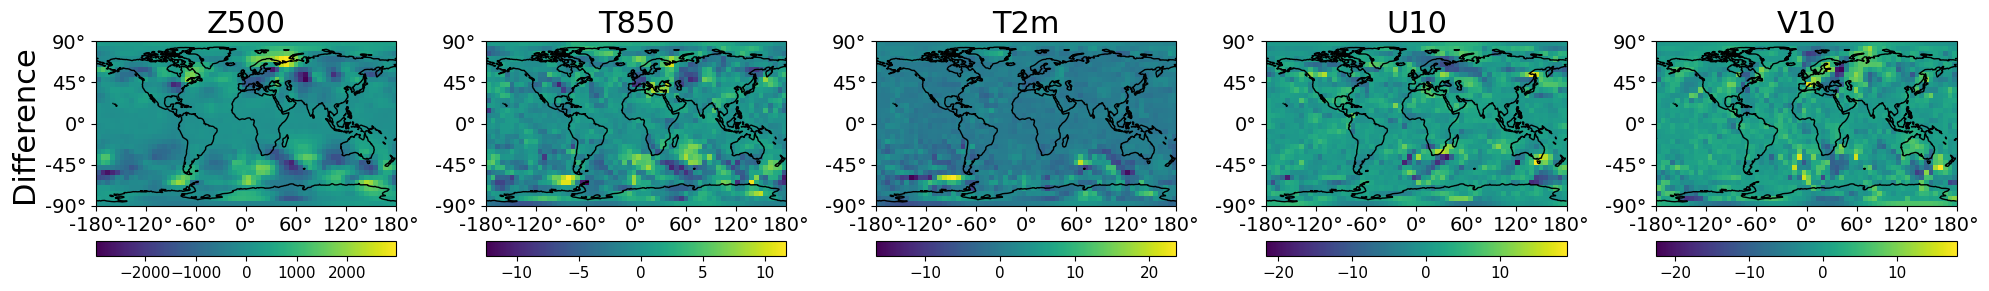

In [59]:
# lead_time = {0 ~ 11} representing 6~72 hours lead time

lead_time = -1

plot_images1(original_samples_unnormlalized, 'True', lead_time)
plot_images1(generated_samples_unnormlalized, 'Predict', lead_time)
plot_images1(original_samples_unnormlalized-generated_samples_unnormlalized, 'Difference', lead_time)

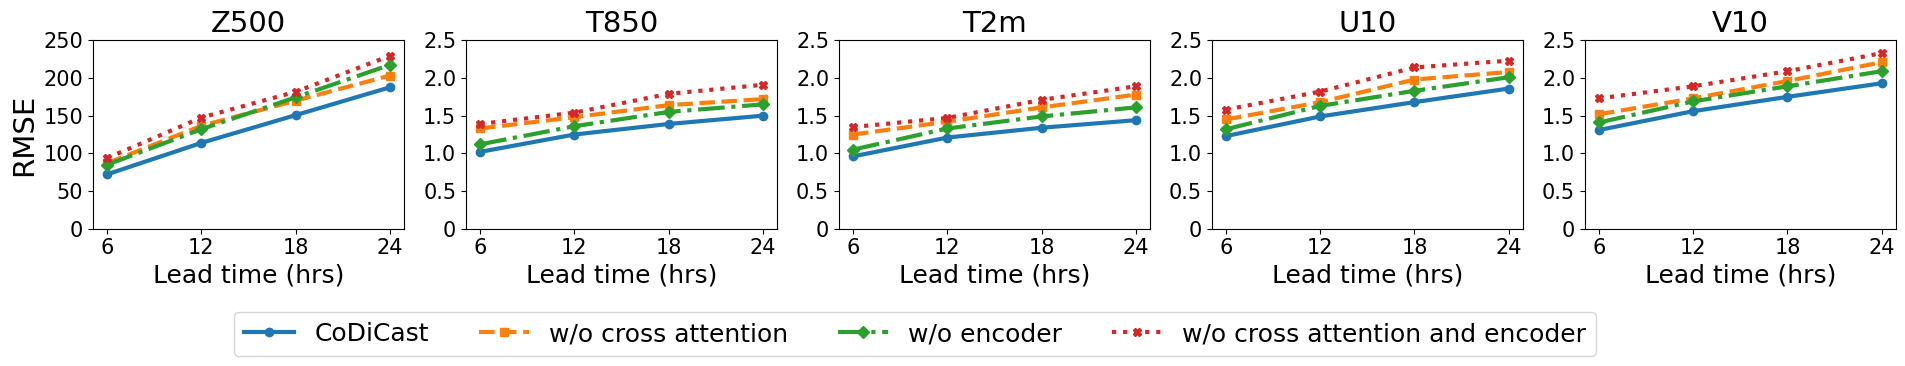

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# First RMSE matrix == full
rmse1 = np.array([
    [73.1, 114.2, 152.4, 186.5],
    [1.02, 1.26,  1.41,  1.52],
    [0.95, 1.21,  1.34,  1.44],
    [1.24, 1.50,  1.68,  1.87],
    [1.30, 1.56,  1.75,  1.94]
])

# Second RMSE matrix == without cross_attn
rmse2 = np.array([
    [86.9, 136.6, 169.9, 203.2],
    [1.33, 1.48,  1.64,  1.72],
    [1.25, 1.42,  1.61,  1.78],
    [1.45, 1.68,  1.98,  2.08],
    [1.52, 1.73,  1.96,  2.21]
])

# Third RMSE matrix == without encoder
rmse3 = np.array([
    [ 84.9, 132.1, 174.3, 217.4],
    [ 1.12, 1.36,  1.55,  1.65],
    [ 1.05, 1.33,  1.49,  1.61],
    [ 1.32, 1.63,  1.83,  2.01],
    [ 1.41, 1.69,  1.89,  2.09]
])

# Forth RMSE matrix == without cross_attn and encoder
rmse4 = np.array([
    [ 93.8, 147.5, 181.7, 229.4],
    [ 1.39,  1.54,  1.79,  1.91],
    [ 1.35,  1.47,  1.71,  1.89],
    [ 1.58,  1.82,  2.14,  2.23],
    [ 1.73,  1.89,  2.09,  2.33]
])

# Prediction lengths
prediction_lengths = np.array([6, 12, 18, 24])
variable_names = ['Z500', 'T850', 'T2m', 'U10', 'V10']

# Define line styles and markers for each RMSE matrix
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', 'D', 'X']
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Create subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 3.5))

# Plot each variable in a separate subplot
for i in range(rmse1.shape[0]):
    # axs[i].plot(prediction_lengths, rmse1[i, :], line_styles[0], marker=markers[0], color=colors[0], label='RMSE 1')
    # axs[i].plot(prediction_lengths, rmse2[i, :], line_styles[1], marker=markers[1], color=colors[1], label='RMSE 2')
    # axs[i].plot(prediction_lengths, rmse3[i, :], line_styles[2], marker=markers[2], color=colors[2], label='RMSE 3')
    # axs[i].plot(prediction_lengths, rmse4[i, :], line_styles[2], marker=markers[2], color=colors[2], label='RMSE 3')
    axs[i].plot(prediction_lengths, rmse1[i, :], line_styles[0], marker=markers[0], label='CoDiCast', linewidth=3)
    axs[i].plot(prediction_lengths, rmse2[i, :], line_styles[1], marker=markers[1], label='w/o cross attention', linewidth=3)
    axs[i].plot(prediction_lengths, rmse3[i, :], line_styles[2], marker=markers[2], label='w/o encoder', linewidth=3)
    axs[i].plot(prediction_lengths, rmse4[i, :], line_styles[3], marker=markers[3], label='w/o cross attention and encoder', linewidth=3)
    axs[i].set_title(variable_names[i], fontsize=21)
    axs[i].set_xlabel('Lead time (hrs)', fontsize=18)
    axs[i].set_xticks(prediction_lengths)
    axs[i].set_xticklabels(prediction_lengths, fontsize=15)  # Adjust x-tick label size
    axs[i].tick_params(axis='y', labelsize=14)  # Adjust y-tick label size
    if i == 0:
        axs[i].set_ylabel('RMSE', fontsize=21)
        axs[i].set_yticks([0, 50, 100, 150, 200, 250])  # Set specific y-tick labels for the first subplot
        axs[i].set_yticklabels([0, 50, 100, 150, 200, 250], fontsize=15)  # Set y-tick labels for the first subplot
    else:
        axs[i].set_yticks([0, 0.5, 1.0, 1.5, 2.0, 2.5])  # Set specific y-tick labels for last 4 subplots
        axs[i].set_yticklabels([0, 0.5, 1.0, 1.5, 2.0, 2.5], fontsize=15)  # Set y-tick labels


# Adjust space between subplots
plt.subplots_adjust(wspace=0.7)  # Increase the space between subplots

# Create a single legend for the entire figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.09), ncol=4, fontsize=18)

# plt.suptitle('RMSE for Different Variables Across Prediction Lengths', fontsize=20)
plt.tight_layout(rect=[0.04, 0.08, 1, 0.96])
plt.show()

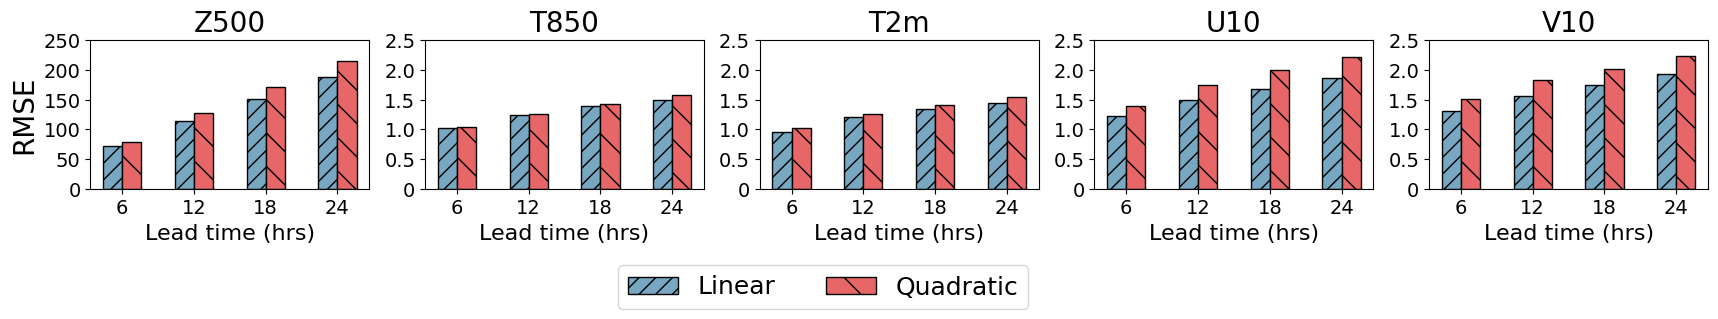

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# First RMSE matrix == full
rmse1 = np.array([
    [73.1, 114.2, 152.4, 186.5],
    [1.02, 1.26,  1.41,  1.52],
    [0.95, 1.21,  1.34,  1.44],
    [1.24, 1.50,  1.68,  1.87],
    [1.30, 1.56,  1.75,  1.94]
])

# Second RMSE matrix == without cross_attn
rmse2 = np.array([
    [78.7, 126.8, 171.1, 215.1],
    [1.04, 1.26,  1.42,  1.58],
    [1.03, 1.26,  1.41,  1.54],
    [1.40, 1.75,  1.99,  2.21],
    [1.51, 1.82,  2.01,  2.23]
])

# Prediction lengths
prediction_lengths = np.array([6, 12, 18, 24])
variable_names = ['Z500', 'T850', 'T2m', 'U10', 'V10']

# Create subplots
fig, axs = plt.subplots(1, 5, figsize=(18, 3))

bar_width = 1.6  # Width of the bars
offset = bar_width / 2  # Offset for each set of bars

# Define colors for each RMSE matrix
# colors = ['#F195AA', '#75B1DA', '#ECC46E']
colors = ['#78A7C2', '#E8B77A', '#E76768']

hatches = ['//', '\\', '..']

# Plot each variable in a separate subplot
for i in range(rmse1.shape[0]):
    axs[i].bar(prediction_lengths - offset, rmse1[i, :], width=bar_width, label='Linear', color=colors[0], hatch=hatches[0], edgecolor='black')
    # axs[i].bar(prediction_lengths, rmse2[i, :], width=bar_width, label='RMSE 2', color=colors[1], hatch=hatches[1], edgecolor='black')
    axs[i].bar(prediction_lengths + offset, rmse2[i, :], width=bar_width, label='Quadratic', color=colors[2], hatch=hatches[1], edgecolor='black')
    axs[i].set_title(variable_names[i], fontsize=20)
    axs[i].set_xlabel('Lead time (hrs)', fontsize=16)
    axs[i].set_xticks(prediction_lengths)
    axs[i].set_xticklabels(prediction_lengths, fontsize=14)  # Adjust x-tick label size
    axs[i].tick_params(axis='y', labelsize=14)  # Adjust y-tick label size
    axs[i].set_ylim([0, max(max(rmse1[i, :]), max(rmse2[i, :]), max(rmse3[i, :]))])  # Adjust y-axis scale to fit the data with some margin
    if i == 0:
        axs[i].set_ylabel('RMSE', fontsize=20)
        axs[i].set_yticks([0, 50, 100, 150, 200, 250])  # Set specific y-tick labels for the first subplot
        axs[i].set_yticklabels([0, 50, 100, 150, 200, 250], fontsize=14)  # Set y-tick labels for the first subplot
    else:
        axs[i].set_yticks([0, 0.5, 1.0, 1.5, 2.0, 2.5])  # Set specific y-tick labels for last 4 subplots
        axs[i].set_yticklabels([0, 0.5, 1.0, 1.5, 2.0, 2.5], fontsize=14)  # Set y-tick labels

# Create a single legend for the entire figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.1), ncol=2, fontsize=18)

# plt.suptitle('RMSE for Different Variables Across Prediction Lengths', fontsize=20)
plt.tight_layout(rect=[0.04, 0.08, 1, 0.96])
plt.show()
